<h1 style="text-align: center;">Storck Prediction with <strong>RNN</strong></h1>

- The first section of the notebook aims to predict the exact stock price from the previous 20 time steps. Results are suboptimal due to erratic nature of stock market. This section use a simple RNN
- The second part aims to predict where there would be a rise or fall in the market. This section uses an LSTM

In [28]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [29]:
def make_seq_data(series, T):
    X = []
    y = []
    for t in range(len(series) - T):
        X.append(series[t:t+T])
        y.append(series[t+T])
    
    X = np.array(X)
    y = np.array(y).reshape(-1,1)

    return X, y

In [30]:
## reading the data
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [31]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


## Section 1: Price Prediction

In [32]:
series = df[["close"]]

## scaling 
scaler = StandardScaler()
scaler.fit(series[:-len(series)//2])
series = scaler.transform(series)

In [33]:
## creating the data
T = 20
X = []
y = []
for t in range(len(series) - T):
    X.append(series[t:t+T])
    y.append(series[t+T])

X = np.array(X)
y = np.array(y).reshape(-1,1)

In [34]:
N = len(series)
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(y[-N//2:].astype(np.float32))

In [35]:
## creating the model
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.D = input_size
        self.K = output_size
        self.M = hidden_size
        self.L = num_layers
        
        ## lstm layer
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first = True
        )

        ## full connection
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)

        out,_ = self.rnn(X, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out

In [36]:
## preparing for training
model = RNN(input_size=1,
            output_size=1,
            hidden_size=20,
            num_layers=1
           )

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [37]:
## training function
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs):
    train_losses = []
    test_losses = []
    
    for it in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)

        
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test)

        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss.item()}. Test Loss: {test_loss.item()}")

    return train_losses, test_losses

In [38]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    300
                                   )

Epoch 1/300, Train Loss: 0.9446077346801758. Test Loss: 6.791381359100342
Epoch 2/300, Train Loss: 0.8668385148048401. Test Loss: 6.277840614318848
Epoch 3/300, Train Loss: 0.7907534837722778. Test Loss: 5.740545272827148
Epoch 4/300, Train Loss: 0.7106574773788452. Test Loss: 5.17421817779541
Epoch 5/300, Train Loss: 0.6226322650909424. Test Loss: 4.583230018615723
Epoch 6/300, Train Loss: 0.5238250494003296. Test Loss: 3.9756317138671875
Epoch 7/300, Train Loss: 0.41419559717178345. Test Loss: 3.364792585372925
Epoch 8/300, Train Loss: 0.29793018102645874. Test Loss: 2.775193691253662
Epoch 9/300, Train Loss: 0.19031642377376556. Test Loss: 2.2219083309173584
Epoch 10/300, Train Loss: 0.13131225109100342. Test Loss: 1.7101163864135742
Epoch 11/300, Train Loss: 0.14584998786449432. Test Loss: 1.2578020095825195
Epoch 12/300, Train Loss: 0.18788324296474457. Test Loss: 0.9123694896697998
Epoch 13/300, Train Loss: 0.17112453281879425. Test Loss: 0.7059054374694824
Epoch 14/300, Train Lo

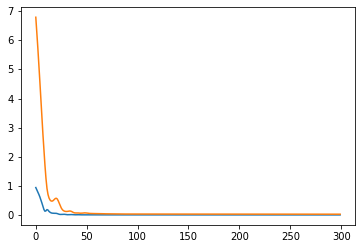

In [39]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

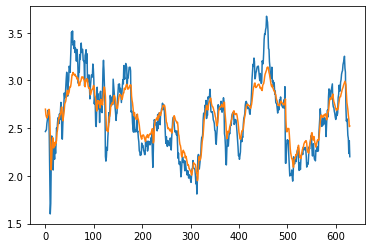

In [40]:
## wrong way to predict
with torch.no_grad(): 
    preds = model(X_test)
    plt.plot(y_test)
    plt.plot(preds) 

In [41]:
## correct preds
last_x = X_test[0].numpy().flatten()
preds = []
for i in range(len(y_test)):
    pred = model(torch.from_numpy(last_x.reshape(1,T,1).astype(np.float32))).item()
    preds.append(pred)
    last_x = np.append(last_x[1:],pred)

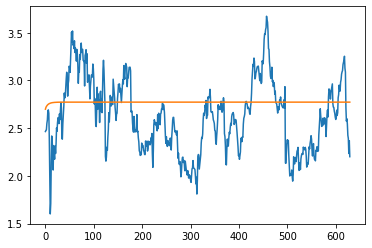

In [42]:
plt.plot(y_test)
plt.plot(preds)
plt.show()

In [43]:
X.shape

(1239, 20, 1)

In [44]:
## predicting returns
df["returns"] = df["close"] - df["close"].shift(1)

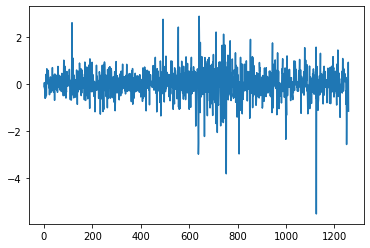

In [45]:
## plotting the returns
plt.plot(df["returns"])
plt.show()

In [52]:
series = df[["returns"]][1:]

## normalilzing
# series = series.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(series[:-len(series)//2])

series = scaler.transform(series)

T = 20
X, y = make_seq_data(series, T)

In [54]:
N = len(series)
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(y[-N//2:].astype(np.float32))

In [55]:
## preparing for training
model = RNN(input_size=1,
            output_size=1,
            hidden_size=20,
            num_layers=1
           )

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [56]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    300
                                   )

Epoch 1/300, Train Loss: 1.043982982635498. Test Loss: 2.3883543014526367
Epoch 2/300, Train Loss: 1.0259157419204712. Test Loss: 2.384127140045166
Epoch 3/300, Train Loss: 1.0154505968093872. Test Loss: 2.388273000717163
Epoch 4/300, Train Loss: 1.0136620998382568. Test Loss: 2.401848793029785
Epoch 5/300, Train Loss: 1.0168874263763428. Test Loss: 2.4158077239990234
Epoch 6/300, Train Loss: 1.0162352323532104. Test Loss: 2.4179766178131104
Epoch 7/300, Train Loss: 1.0133429765701294. Test Loss: 2.4138991832733154
Epoch 8/300, Train Loss: 1.0109155178070068. Test Loss: 2.40887713432312
Epoch 9/300, Train Loss: 1.0097147226333618. Test Loss: 2.405033588409424
Epoch 10/300, Train Loss: 1.0094633102416992. Test Loss: 2.402756452560425
Epoch 11/300, Train Loss: 1.009649634361267. Test Loss: 2.401846170425415
Epoch 12/300, Train Loss: 1.009860873222351. Test Loss: 2.4020001888275146
Epoch 13/300, Train Loss: 1.009867787361145. Test Loss: 2.4029834270477295
Epoch 14/300, Train Loss: 1.00960

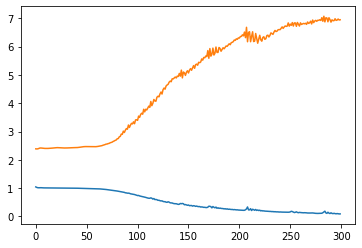

In [57]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

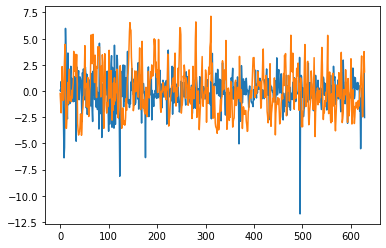

In [58]:
## wrong way to predict
with torch.no_grad(): 
    preds = model(X_test)
    plt.plot(y_test)
    plt.plot(preds) 

In [59]:
## correct preds
last_x = X_test[0].numpy().flatten()
preds = []
for i in range(len(y_test)):
    pred = model(torch.from_numpy(last_x.reshape(1,T,1).astype(np.float32))).item()
    preds.append(pred)
    last_x = np.append(last_x[1:],pred)

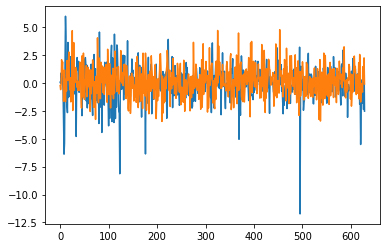

In [60]:
plt.plot(y_test)
plt.plot(preds)
plt.show()

## Section 2: Rise and Fall

This section of the notebook aims at predicting whether there would be a `rise` or `fall` in the stocks. Again these results are suboptimal to to the erratic nature of the stock market

In [201]:
new_df = df.loc[1:,["open", "high", "low", "close", "volume", "returns"]]
X = new_df[["open", "high", "low", "close", "volume"]]
y = new_df["returns"] > 0

In [202]:
T = 10
N = len(X) - T
D = X.shape[1]
Ntrain = N*2//3
# Ntrain = len(X)*2//3
scaler = StandardScaler()
scaler.fit(X.iloc[:Ntrain+T-1])
X = scaler.transform(X)

In [203]:
X_train = np.zeros((Ntrain, T, D))
y_train = np.zeros((Ntrain, 1))

## creating training data
for t in range(Ntrain):
    X_train[t,:,:] = X[t:t+T]
    y_train[t] = y[t+T]

## creating testing data
X_test = np.zeros((N-Ntrain, T, D))
y_test = np.zeros((N-Ntrain, 1))


for t in range(N-Ntrain):
    u = Ntrain + t
    X_test[t,:,:] = X[u:u+T] 
    y_test[t] = y[u+T] 

In [204]:
model = RNN(input_size = 5,
            hidden_size = 50,
            num_layers = 2,
            output_size = 1
           )

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [205]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [206]:
train_losses, test_losses = full_gd(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test,
    80
)

Epoch 1/80, Train Loss: 0.6935879588127136. Test Loss: 0.6932311654090881
Epoch 2/80, Train Loss: 0.6933827996253967. Test Loss: 0.6967992782592773
Epoch 3/80, Train Loss: 0.6917111873626709. Test Loss: 0.6957947015762329
Epoch 4/80, Train Loss: 0.6915823817253113. Test Loss: 0.6940645575523376
Epoch 5/80, Train Loss: 0.6917009353637695. Test Loss: 0.6931746602058411
Epoch 6/80, Train Loss: 0.6915682554244995. Test Loss: 0.6930054426193237
Epoch 7/80, Train Loss: 0.6912273168563843. Test Loss: 0.6932938694953918
Epoch 8/80, Train Loss: 0.6908673644065857. Test Loss: 0.6938745975494385
Epoch 9/80, Train Loss: 0.6905314326286316. Test Loss: 0.6942113041877747
Epoch 10/80, Train Loss: 0.6901006102561951. Test Loss: 0.6934290528297424
Epoch 11/80, Train Loss: 0.6896241307258606. Test Loss: 0.6915168166160583
Epoch 12/80, Train Loss: 0.6887799501419067. Test Loss: 0.6917900443077087
Epoch 13/80, Train Loss: 0.6879869699478149. Test Loss: 0.6933726668357849
Epoch 14/80, Train Loss: 0.6882416

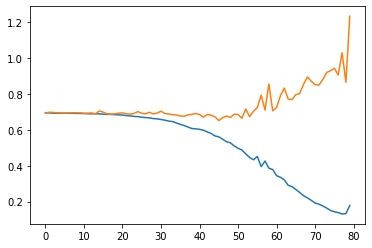

In [207]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

In [208]:
train_acc = 0
test_acc = 0
with torch.no_grad():
    train_acc = ((model(X_train) > 0) == y_train).numpy().mean()
    test_acc = ((model(X_test) > 0) == y_test).numpy().mean()

print(f"Training Accuracy: {train_acc}, Test Accuracy: {test_acc}")

Training Accuracy: 0.9375, Test Accuracy: 0.6850961538461539
